## Importar bibliotecas

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Carga dataset

In [ ]:
data = pd.read_csv('sample_data/chile.csv')
print(data.columns)

Index(['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'event_date',
       'year', 'time_precision', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'region', 'country', 'admin1', 'admin2', 'admin3',
       'location', 'latitude', 'longitude', 'geo_precision', 'source',
       'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3'],
      dtype='object')


## Análisis exploratorio

In [ ]:
for column in data.columns:
    print(column, ":", len(data[column].unique()))

data_id : 6493
iso : 1
event_id_cnty : 6493
event_id_no_cnty : 6493
event_date : 971
year : 3
time_precision : 3
event_type : 6
sub_event_type : 16
actor1 : 38
assoc_actor_1 : 248
inter1 : 7
actor2 : 20
assoc_actor_2 : 111
inter2 : 8
interaction : 26
region : 1
country : 1
admin1 : 17
admin2 : 54
admin3 : 243
location : 371
latitude : 371
longitude : 367
geo_precision : 3
source : 307
source_scale : 13
notes : 6491
fatalities : 5
timestamp : 199
iso3 : 1


In [ ]:
data = data.drop(['data_id','iso', "event_id_cnty", "event_id_no_cnty", "iso3", "country", "region"], axis=1)
print(len(data.columns))
print(data.columns)

24
Index(['event_date', 'year', 'time_precision', 'event_type', 'sub_event_type',
       'actor1', 'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2',
       'inter2', 'interaction', 'admin1', 'admin2', 'admin3', 'location',
       'latitude', 'longitude', 'geo_precision', 'source', 'source_scale',
       'notes', 'fatalities', 'timestamp'],
      dtype='object')


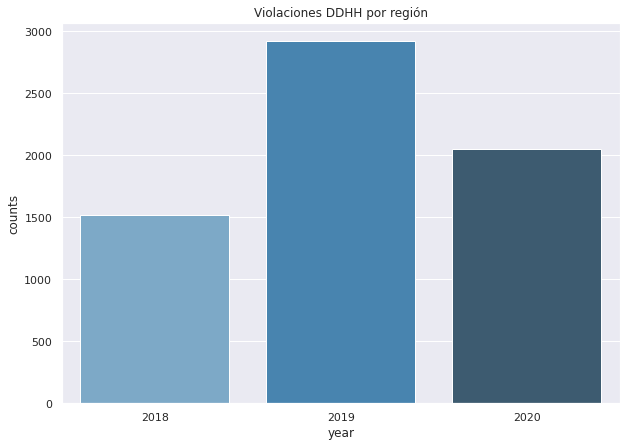

In [ ]:
gr = data.groupby(['year']).size().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(10, 7),nrows=1)
sns.barplot(data=gr, x='year', y='counts', palette="Blues_d",ax=ax)
ax.set_title('Violaciones DDHH por región')
plt.show()
print("")

In [ ]:
from tensorflow import convert_to_tensor
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

label_encoders = dict()
are_object = list()

for column in data.columns:
  if str(data[column].dtype) == "object":
      data[column] = data[column].astype('|S')
      are_object.append(column)

print(are_object)

for is_object in are_object:
  label_encoders[is_object] = LabelEncoder()
  data[is_object] = label_encoders[is_object].fit_transform(data[is_object])
  
features = ['event_date', 'year', 'time_precision', 'sub_event_type',
       'actor1', 'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2',
       'inter2', 'interaction', 'admin1', 'admin2', 'admin3',
       'latitude', 'longitude', 'geo_precision', 'source', 'source_scale',
       'notes', 'fatalities', 'timestamp']

predict = ["location", "event_type"]

X = data[features]
Y = data[predict]

X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, test_size=0.5, random_state=0)

['event_date', 'event_type', 'sub_event_type', 'actor1', 'assoc_actor_1', 'actor2', 'assoc_actor_2', 'admin1', 'admin2', 'admin3', 'location', 'source', 'source_scale', 'notes']


In [ ]:
data.dtypes

event_date          int64
year                int64
time_precision      int64
event_type          int64
sub_event_type      int64
actor1              int64
assoc_actor_1       int64
inter1              int64
actor2              int64
assoc_actor_2       int64
inter2              int64
interaction         int64
admin1              int64
admin2              int64
admin3              int64
location            int64
latitude          float64
longitude         float64
geo_precision       int64
source              int64
source_scale        int64
notes               int64
fatalities          int64
timestamp           int64
dtype: object

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam, RMSprop
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor

def create_model(optimizer='rmsprop', nneuron=14, n_outputs=2):
  
    model = Sequential()
    model.add(Dense(nneuron, input_shape=(X_train.shape[1],), kernel_initializer='normal', activation='relu'))
    model.add(Dense(nneuron//2, kernel_initializer='normal', activation='relu'))
    model.add(Dense(n_outputs, activation="linear", kernel_initializer='normal'))

    if optimizer == "rmsprop":
      opt = RMSprop()
    elif optimizer == "adam":
      opt = Adam()
    elif optimizer == "SGD":
      opt = SGD()
    else:
      return "error"

    model.compile(
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(),
                 tf.keras.metrics.MeanAbsolutePercentageError(), "accuracy"],
        optimizer=opt)
    
    return model

####################

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

model = KerasRegressor(build_fn=create_model, epochs=20, batch_size=5, verbose=0)

optimizers = ['rmsprop', 'adam', 'SGD']
epochs = [10, 50] #early stopping
batches = [5, 10]
#nneurons = [6,12,24,48,96] #
nneurons = [8, 16, 32, 64]

param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, nneuron=nneurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f con %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) con: %r" % (mean, stdev, param))

Best: -23039.342969 con {'batch_size': 5, 'epochs': 50, 'nneuron': 12, 'optimizer': 'rmsprop'}
-24902.452734 (1967.958233) con: {'batch_size': 5, 'epochs': 50, 'nneuron': 6, 'optimizer': 'rmsprop'}
-67633.830469 (139993.383626) con: {'batch_size': 5, 'epochs': 50, 'nneuron': 6, 'optimizer': 'adam'}
nan (nan) con: {'batch_size': 5, 'epochs': 50, 'nneuron': 6, 'optimizer': 'SGD'}
-23039.342969 (5391.879130) con: {'batch_size': 5, 'epochs': 50, 'nneuron': 12, 'optimizer': 'rmsprop'}
-25821.590234 (6969.544175) con: {'batch_size': 5, 'epochs': 50, 'nneuron': 12, 'optimizer': 'adam'}
nan (nan) con: {'batch_size': 5, 'epochs': 50, 'nneuron': 12, 'optimizer': 'SGD'}
-24977.639648 (1960.820826) con: {'batch_size': 5, 'epochs': 50, 'nneuron': 24, 'optimizer': 'rmsprop'}
-133285.678320 (232670.919627) con: {'batch_size': 5, 'epochs': 50, 'nneuron': 24, 'optimizer': 'adam'}
nan (nan) con: {'batch_size': 5, 'epochs': 50, 'nneuron': 24, 'optimizer': 'SGD'}
-23573.329053 (5488.257933) con: {'batch_s

In [ ]:
-23039.342969 con {'batch_size': 5, 'epochs': 50, 'nneuron': 12, 'optimizer': 'rmsprop'}
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=5, verbose=0)

In [ ]:
from sklearn import tree, ensemble
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

forest = ensemble.RandomForestRegressor(max_depth=15, min_samples_leaf=5)
ada_boost = MultiOutputRegressor(ensemble.AdaBoostRegressor())

forest.fit(X_train, Y_train)
ada_boost.fit(X_train, Y_train)

print(forest.score(X_val, Y_val))
predictions = forest.predict(X_val)
print(mean_squared_error(Y_val, predictions))
print(ada_boost.score(X_val, Y_val))

0.930003804088907
496.49449423236763
0.8734110507568623


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
